## MH4518 Group Project

Product: https://derivative.credit-suisse.com/ch/ch/en/detail/drop-back-certificate-s-p-500/CH1199361879/119936187


### 1. Initial Set-up

<ol>
<li> Set directories
<li> Install dependencies
<li> Import libraries
<li> Suppress Warnings (Optional)
</ol>

NOTE: Ensure you are using the correct kernel to run the Jupyter Notebook with the correctly set root driectory.

In [1]:
import os, sys

# Set the root directory accordingly
ROOT_DIR = "D:\Coding\MH4518"
os.chdir(ROOT_DIR)
#sys.path.append(ROOT_DIR)

# These directories are set relative to root
DATA_DIR = os.path.join(ROOT_DIR, "data")
SAVE_DIR = os.path.join(ROOT_DIR, "simulations")

In [2]:
# Install additional libraries using pip
#! pip install -r requirements.txt

# Or if you have Conda installed (reccommended)
# conda env create -f environment.yml

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

from numba import jit, njit
from scipy.optimize import minimize
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [4]:
# OPTIONAL: Suppresing the deprecation notices while using numba and matplotlib (reccommended)
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.filterwarnings('ignore', module = "matplotlib\..*" )
warnings.filterwarnings('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings('ignore', category=NumbaPendingDeprecationWarning)

### 2. Loading Data

The asset and product prices as well as the interest and dividend rates were collected and preprocessed using the notebook present in the `/data` directory.

<ol>
<li> daily_interest_rates.csv
<li> asset_prices_processed.csv
<li> product_prices_processed.csv
<li> SPY_quarterly_dividend_rates.csv
</ol>
<br>

However for our simulations we will only focus on the following time period,

<li> Start date: 09-08-2022
<li> End date: 09-11-2023

In [55]:
# Load asset prices
asset_prices = pd.read_csv(os.path.join(DATA_DIR, "asset_prices_processed.csv"))
asset_prices["date"] = pd.to_datetime(asset_prices["date"])
asset_prices = asset_prices.set_index("date")

# Load product prices
product_prices = pd.read_csv(os.path.join(DATA_DIR, "product_prices_processed.csv"))
product_prices["date"] = pd.to_datetime(product_prices["date"])
product_prices = product_prices.set_index("date")

# Load daily interest rates
interest_rates = pd.read_csv(os.path.join(DATA_DIR, "daily_interest_rates.csv"))
interest_rates["date"] = pd.to_datetime(interest_rates["date"])

# Separate the 1 year and 2 year interest rate
interest_rate_1_year = interest_rates[["date", "1 Yr"]]
interest_rate_2_year = interest_rates[["date", "2 Yr"]]
interest_rates = interest_rates.set_index("date")

# Load quarterly dividend rates
dividend_rates = pd.read_csv(os.path.join(DATA_DIR, "SPY_quarterly_dividend_rates.csv"))
dividend_rates["date"] = pd.to_datetime(dividend_rates["date"])
dividend_rates = dividend_rates.set_index("date")

In [56]:
# Visualizing the dividend rates (for example)
interest_rate_1_year

,date,1 Yr
0,2022-07-19,3.18
1,2022-07-20,3.18
2,2022-07-21,3.11
3,2022-07-22,3.01
4,2022-07-25,3.07
...,...,...
325,2023-11-03,5.29
326,2023-11-06,5.33
327,2023-11-07,5.33
328,2023-11-08,5.34


### 3. Payoff Function

In [7]:
def find_trigger_price(S_path, trigger):
    '''
    Returns the price that triggered the event, if it exists, else None.
    '''
    # Return the first price that triggers the event
    for price in S_path:
        if price <= trigger:
            return price
        
    return None


def calculate_payoff(S_path, Y_0 = 1000, rate = 0.0985, years = 3):
    '''
    Computes the payoff of a simulated path.
    '''
    S_0 = 3790.38   # From factsheet
    S_t1 = find_trigger_price(S_path, trigger = 3411.3420)   # 0.90 * S_0
    S_t2 = find_trigger_price(S_path, trigger = 3221.8230)   # 0.85 * S_0
    S_t3 = find_trigger_price(S_path, trigger = 3032.3040)   # 0.80 * S_0
    S_T = S_path[-1]

    # Edge Case
    if(S_t3 == 0 or S_t2 == 0 or S_t1 == 0):
        return 0

    # 1. Fixed returns independent of trigger events
    Y_T = (0.55*Y_0) * (S_T/S_0)

    # 2. Adjusted returns after trigger events
    if S_t3 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2 + S_T/S_t3)
    elif S_t2 is not None:
        multiplier = (S_T/S_t1 + S_T/S_t2)
    elif S_t1 is not None:
        multiplier = (S_T/S_t1)
    else:
        multiplier = 0.0
    Y_T += (0.15*Y_0) * multiplier

    # 3. Daily accrued interest of 9.85% p.a.
    if S_t3 is not None:
        principal = 0.0
    elif S_t2 is not None:
        principal = (0.15*Y_0)
    elif S_t1 is not None:
        principal = (0.30*Y_0)
    else:
        principal = (0.45*Y_0)
    Y_T += principal * (1 + rate * years)
    
    assert Y_T >= 0.0   # Sanity Check
    return Y_T


def calculate_payoff_without_triggers(S_path, Y_0 = 1000, rate = 0.0985, years = 3):
    '''
    Computes the payoff of a simulated path without the trigger events (barriers).
    '''
    S_0 = 3790.38   # From factsheet
    S_T = S_path[-1]

    # Payoff formula is fixed
    Y_T = (0.55*Y_0) * (S_T/S_0) + (0.45*Y_0) * (1 + rate * years)
    
    assert Y_T >= 0.0   # Sanity Check
    return Y_T

In [8]:
# OPTIONAL: Testing the payoff function with values in the factsheet (Flawed, all triggers are hit)
S_0 = 3790.38
S_path_partial = [3790.41, 3800.15, 3373.44, 4000.00, 3183.92, 2994.40]
S_T = [0.0, 2653.27, 3032.3, 3411.34, 3790.38, 4169.42, 4548.46, 4927.49]

for final_closing_price in S_T:
    S_path = S_path_partial + [final_closing_price]
    payoff = calculate_payoff(S_path)

    print(f"S_T = {final_closing_price} \t   Performance of Asset = {100*(final_closing_price - S_0)/S_0:.2f}% \t Performance of Certificate = {(payoff - 1000)/10:.2f}% \t Payoff = {payoff:.2f}")

S_T = 0.0 	   Performance of Asset = -100.00% 	 Performance of Certificate = -100.00% 	 Payoff = 0.00
S_T = 2653.27 	   Performance of Asset = -30.00% 	 Performance of Certificate = -23.91% 	 Payoff = 760.89
S_T = 3032.3 	   Performance of Asset = -20.00% 	 Performance of Certificate = -13.04% 	 Payoff = 869.59
S_T = 3411.34 	   Performance of Asset = -10.00% 	 Performance of Certificate = -2.17% 	 Payoff = 978.29
S_T = 3790.38 	   Performance of Asset = 0.00% 	 Performance of Certificate = 8.70% 	 Payoff = 1086.98
S_T = 4169.42 	   Performance of Asset = 10.00% 	 Performance of Certificate = 19.57% 	 Payoff = 1195.68
S_T = 4548.46 	   Performance of Asset = 20.00% 	 Performance of Certificate = 30.44% 	 Payoff = 1304.38
S_T = 4927.49 	   Performance of Asset = 30.00% 	 Performance of Certificate = 41.31% 	 Payoff = 1413.08


### 4. Geometric Brownian Motion

Implmentation of the Black-Scholes model for pricing. THe form derived from Ito's lemma was used. This will be our baseline model.

In [9]:
@njit
def simulate_GBM(num_sim, S_0, r, sigma, delta_t, T, Z):  # NOTE: For exact GMB simply set r = mu while calling
  """
  r is the daily interest rate
  sigma is daily volatility
  T is actually tau = T - t (in years)
  delta_t is 1 / 252
  Z is the random variates sampled from N(0, 1)
  """
  # Initializations
  v = r - 0.5*(sigma**2)
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)

  # We are using the form derived by Ito's lemma 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      log_diff = v*delta_t + (sigma*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix

### 5. Heston Model

Implementation of the Cox-Ingersoll-Ross model for pricing.

In [10]:
@njit
def simulate_Heston_var(num_sim, S_0, S_mu, S_Sigma, kappa, corr, delta_t, T, Z1, Z2):
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)
 
  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      prev = S_matrix[i][j-1]
      S_matrix[i][j] = prev + (kappa*(S_mu-prev))*delta_t + np.sqrt(S_Sigma*prev*delta_t)*(corr*Z1[i][j-1]+np.sqrt(1-corr**2)*Z2[i][j-1])
      if(S_matrix[i][j]<=0):
        S_matrix[i][j] = S_mu
      
  return S_matrix

In [11]:
@njit
def simulate_Heston(num_sim, S_0, r, sigma, delta_t, T, Z):
  num_periods = int(T/delta_t)
  S_matrix = np.zeros(shape=(num_sim, num_periods + 1), dtype=np.float64)

  for i in range(num_sim):
    S_matrix[i][0] = S_0
    for j in range(1, num_periods + 1):
      v = r - 0.5*(sigma[i][j]**2)
      log_diff = v*delta_t + (sigma[i][j]*np.sqrt(delta_t) * Z[i][j-1])
      S_matrix[i][j] = S_matrix[i][j-1]*np.exp(log_diff)

  return S_matrix

### 6. Backtesting the Models

We take 252 day long windows of data for each iteration.

eg: The first window begins on 9th August, 2022 and ends on 8th August, 2023 and we price the product on 9th August.

#### 6.1 Parameters and Rolling Window

In [12]:
# Create a market calendar for date handling
nyse = mcal.get_calendar('NYSE')
product_lifetime = nyse.schedule(start_date='2022-07-14', end_date='2025-07-14')
print(len(product_lifetime))

753


In [13]:
# Parameters for each set of simulations
num_sim = 10000    # Push to 1,000,000
delta_t = 1/252
num_periods = len(product_lifetime)
T = num_periods/252
# T is in years
# delta t_is also in years

In [14]:
# One set of simulations for each date in [start_date, end_date]
window_size = 252
start_date = pd.to_datetime("2023-08-09")
end_date = pd.to_datetime("2023-11-09")

simulation_dates = product_prices.index[(product_prices.index >= start_date) & (product_prices.index <= end_date)]
print(f"{len(simulation_dates)} days")
print(f"Start Date: {simulation_dates[0]}; End date: {simulation_dates[-1]}")

67 days
Start Date: 2023-08-09 00:00:00; End date: 2023-11-09 00:00:00


In [15]:
# We shall sample a window of size 252 from the historical data (EXCLUDING the current date)
backtest_windows = []   # Prices only
backtest_windows_with_dates = []
previous_window_end_date = None

for window_end_date in simulation_dates:
    # For each date the product was prices, we need 252 points BEFORE this date
    try:
        window_start_index = asset_prices.index.get_loc(window_end_date) - window_size
    except:
        window_start_index = asset_prices.index.get_loc(previous_window_end_date) - window_size + 1
        print(f"Asset not priced on {window_end_date}. Using data up till the previous date!")

    assert window_start_index >= 0

    # Slice the dataset according to the window
    window_start_date = asset_prices.index[window_start_index]
    window_asset_data = asset_prices[(asset_prices.index >= window_start_date) & (asset_prices.index < window_end_date)]

    # Collect all the windows
    assert len(window_asset_data) == window_size
    backtest_windows_with_dates.append(window_asset_data)   # For validatiuon purposes
    backtest_windows.append(np.array(window_asset_data["value"]))
    
    # For handling edge cases in the try-except block
    previous_window_end_date = window_end_date

print(f"Collected data for {len(backtest_windows)} windows of size {window_size} each.")

Asset not priced on 2023-09-04 00:00:00. Using data up till the previous date!
Asset not priced on 2023-11-09 00:00:00. Using data up till the previous date!
Collected data for 67 windows of size 252 each.


In [16]:
# Validating the rolling window boundaries
for x, y in zip(simulation_dates, backtest_windows_with_dates):
    print(f"Pricing asset on - \t\t{x}.")
    print(f"We have data till - \t{y.index[-1]}.\n")

Pricing asset on - 		2023-08-09 00:00:00.
We have data till - 	2023-08-08 00:00:00.

Pricing asset on - 		2023-08-10 00:00:00.
We have data till - 	2023-08-09 00:00:00.

Pricing asset on - 		2023-08-11 00:00:00.
We have data till - 	2023-08-10 00:00:00.

Pricing asset on - 		2023-08-14 00:00:00.
We have data till - 	2023-08-11 00:00:00.

Pricing asset on - 		2023-08-15 00:00:00.
We have data till - 	2023-08-14 00:00:00.

Pricing asset on - 		2023-08-16 00:00:00.
We have data till - 	2023-08-15 00:00:00.

Pricing asset on - 		2023-08-17 00:00:00.
We have data till - 	2023-08-16 00:00:00.

Pricing asset on - 		2023-08-18 00:00:00.
We have data till - 	2023-08-17 00:00:00.

Pricing asset on - 		2023-08-21 00:00:00.
We have data till - 	2023-08-18 00:00:00.

Pricing asset on - 		2023-08-22 00:00:00.
We have data till - 	2023-08-21 00:00:00.

Pricing asset on - 		2023-08-23 00:00:00.
We have data till - 	2023-08-22 00:00:00.

Pricing asset on - 		2023-08-24 00:00:00.
We have data till - 	20

#### 6.2 Interpolating the Interest Rate Curves

In [39]:
maturities = np.array([1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
interest_rates.columns = maturities

# The 4 month interest rate is a bit sparse
interest_rates = interest_rates.dropna(how='any', axis=1)
maturities = interest_rates.columns.to_numpy()
interest_rates.shape

(330, 12)

In [40]:
curves = []
for date in simulation_dates:
    try:
        interest_rate = interest_rates.loc[date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, interest_rate)
        curves.append(curve_fit)

    except KeyError:
        # Handle the case where the rate is not found
        print(f"Rate not found for date {date}, using the rate from the previous date.")
        previous_date = interest_rates.index[interest_rates.index <= date].max()
        corrected_rate = interest_rates.loc[previous_date].to_numpy()
        curve_fit, status = calibrate_ns_ols(maturities, corrected_rate)
        curves.append(curve_fit)

    except Exception as e:
        print(f"An error occurred for date {date}: {e}")

Rate not found for date 2023-09-04 00:00:00, using the rate from the previous date.
Rate not found for date 2023-10-09 00:00:00, using the rate from the previous date.


#### 6.3 Helper Functions

In [20]:
def get_dividend_rate(date):
    # We only collected the rates relavant for our timeframe
    assert date > pd.to_datetime('2022-06-17')

    # Find the relavant quarter and return the dividend rate
    for quarter_date in dividend_rates.index:
        if date >= quarter_date:
            return dividend_rates.loc[quarter_date, 'dividends']

    print("Returning last rate!")
    return dividend_rates.loc[quarter_date, 'dividend_rate']

In [22]:
def loss(inp, variances, log_prices):
    r, reversion, mean_var, sigma_var, rho = inp
    sigma_var=sigma_var**(1/2)
    term = 0.0
    for i in range(1,len(variances)):
        var = variances[i-1]
        nextvar = variances[i]
        term += -np.log(2*3.1415) - np.log(sigma_var) -np.log(var) - 1/2*np.log(1-rho**2) - (nextvar-1-r)**2/(2*var*(1-rho**2))+ rho*(nextvar-1-r)*(nextvar-var-reversion*mean_var+reversion*var)/(var*sigma_var*(1-rho**2) - (nextvar-var-reversion*mean_var+reversion*var)**2/(2*(sigma_var**2)*var*(1-rho**2)))
    return term

In [23]:
def get_stats(variances):
  mu = np.mean(variances)
  sigma = np.std(variances, ddof=1)
  reversion_rate = 1
  return mu, sigma, reversion_rate, variances[len(variances)-1]

In [57]:
def get_lognormal_statistics(prices):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)
  dev_2 = (log_returns-mu)**2
  correlation = pd.Series(log_returns).corr(pd.Series(dev_2))
  mean_sigma, sigma_sigma, reversion, var_inint = get_stats(dev_2)
  res = minimize(lambda x: loss(x,log_returns, dev_2), (mu,reversion,mean_sigma,sigma_sigma, correlation)).x
  return res, var_inint

In [ ]:
# Generating a common random variable/common randomness matrix for GBM
Z_matrix = np.random.normal(0, 1, size=(len(simulation_dates), num_sim, num_periods))

In [25]:
# Generating a common random variable/common randomness matrix for Heston
Hes_matrix = np.random.normal(0, 1, size=(len(simulation_dates), num_sim, num_periods))

#### 6.4 Running the Simulations (aka The Exciting Part)

#### 6.4.1 GBM with Dividends Adjustment

This will be our baseline model.

In [49]:
# GBM with Dividends without Variance Reduction
GBM_Div_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  # Convert date to index (so we can lookup prices and interest rate curves)
  date_index = simulation_dates.get_loc(date)

  # Estimate r
  delta = len(product_lifetime[date:])
  tau = delta / 252    # time diff in years
  curve_fit = curves[date_index]
  r_yearly = curve_fit(tau) / 100    # yearly (interpolated) interest rate

  # Calulcate mu and sigma (we discard mu)
  _, sigma = get_lognormal_statistics(prices, delta_t)    # sigma is daily variance

  # IMPORTANT: Adjust the interest rate based on dividends
  r_adjusted_yearly = r_yearly - get_dividend_rate(date) / 100
  r_adjusted_daily = r_adjusted_yearly / 252

  # Simulate prices, calculate payoff and expected value
  simulated_prices = simulate_GBM(num_sim, prices[-1], r_adjusted_daily, sigma, delta_t, tau, Z=Z_matrix[date_index])
  payoffs = np.exp(-r_adjusted_yearly*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  
  GBM_Div_expected_values.append(expected_value)

#### 6.4.2 Heston Model

In [ ]:
Hes_expected_values = []

for date, prices in zip(simulation_dates, backtest_windows):
  
  date_index = simulation_dates.get_loc(date)
  delta = len(product_lifetime[date:])
  tau = delta / 252 ### time diff in years
  curve_fit = curves[date_index]
  r = curve_fit(tau)/100 ### yearly interest
  res, var_inint= get_lognormal_statistics(prices)  ### all daily indicators
  mu, reversion, mean_sigma, sigma_sigma, correlation = res
  eff_r = r #- get_div_rate(date)/100
  print(mu, mean_sigma, sigma_sigma, reversion, var_inint, correlation)

  variance = simulate_Heston_var(num_sim, var_inint, mean_sigma, sigma_sigma, reversion, correlation, delta_t, tau, Z1=Z_matrix[date_index],Z2=Hes_matrix[date_index])
  simulated_prices = simulate_Heston(num_sim, prices[-1], eff_r/252, variance**(1/2), delta_t, tau, Z=Z_matrix[date_index])
  
  payoffs = np.exp(-eff_r*tau)*np.apply_along_axis(func1d=calculate_payoff, axis=1, arr=simulated_prices)
  expected_value = np.mean(payoffs)
  Hes_expected_values.append(expected_value)

#### 6.5.1 Plotting the Results (aka The Moment of Truth)

In [59]:
simulation_reults = pd.DataFrame(index=simulation_dates)
product_prices = product_prices[product_prices.index >= start_date]
assert len(product_prices) == len(simulation_reults)

# Gather data into a single dataframe
simulation_reults['Actual'] = product_prices["value"]
simulation_reults['GBM_Div'] = GBM_Div_expected_values
simulation_reults['HES'] = Hes_expected_values

simulation_reults.head(10)

,Actual,GBM_Div,CIR
date,,,
2023-08-09,1124.23,1136.852464,1136.166344
2023-08-10,1125.79,1128.213140,1127.482926
2023-08-11,1122.01,1125.717424,1124.948432
2023-08-14,1125.99,1121.588890,1120.527672
2023-08-15,1121.69,1130.065876,1129.344967
2023-08-16,1117.81,1119.270421,1118.133062
2023-08-17,1112.36,1114.264370,1113.183340
2023-08-18,1107.76,1109.779078,1109.035335
2023-08-21,1107.25,1112.060833,1111.148470


In [60]:
# Save results
simulation_reults.to_csv(os.path.join(SAVE_DIR, "HES_Prices_1.csv"))

Text(0, 0.5, 'Derivative Price in USD')

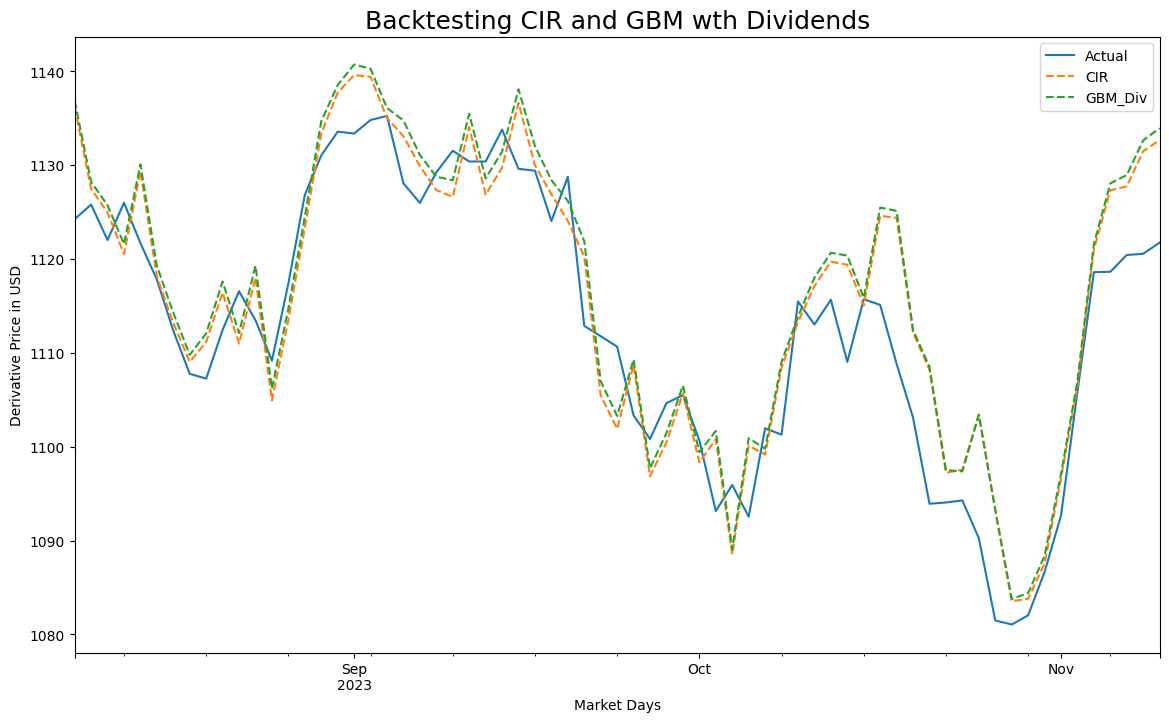

In [61]:
plt.figure(figsize=(14,8))
plt.title('Backtesting HES and GBM wth Dividends', fontdict={"fontsize":18})

simulation_reults['Actual'].plot(legend=True)
simulation_reults['HES'].plot(legend=True, style="--")
simulation_reults['GBM_Div'].plot(legend=True, style="--")

plt.xlabel('Market Days')
plt.ylabel('Derivative Price in USD')

#### 6.5.2 Hmm maybe the Error Decreased?

In [65]:
mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM_Div'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['GBM_Div'].to_list())
print(f'Mean Absolute Error for GBM_Div:\t{mean_abs_error}')
print(f'Mean Squared Error for GBM_Div:\t\t{mean_sq_error}\n')

mean_abs_error=mean_absolute_error(simulation_reults['Actual'].to_list(),simulation_reults['HES'].to_list())
mean_sq_error=mean_squared_error(simulation_reults['Actual'].to_list(),simulation_reults['HES'].to_list())
print(f'Mean Absolute Error for HES:\t\t{mean_abs_error}')
print(f'Mean Squared Error for HES:\t\t{mean_sq_error}\n')

Mean Absolute Error for GBM_Div:	5.407055586108778
Mean Squared Error for GBM_Div:		43.38799028539089

Mean Absolute Error for CIR:		5.1283271963728065
Mean Squared Error for CIR:		38.95355947390155



That's about it for the Heston model. Feel free to explore the other notebooks in `/models` for more models.

#### Thank you!